<a href="https://colab.research.google.com/github/bryaanabraham/Wandering_Guardian/blob/main/GPS_preprocessing/GPS_Data_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [162]:
!pip install gpxpy

In [163]:
!pip install rdp

In [164]:
import gpxpy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdp import rdp

In [165]:
with open('./ONER_2023_FN.gpx') as fh:
  gpx_file = gpxpy.parse(fh)

In [166]:
segment = gpx_file.tracks[0].segments[0]
coords = pd.DataFrame([
    {'lat': p.latitude,
     'lon': p.longitude,
     'ele': p.elevation,
     } for p in segment.points])
coords.head()

,lat,lon,ele
0,50.73446,-2.90010,3.400000
1,50.73446,-2.90010,3.400000
2,50.73425,-2.89969,2.200000
3,50.73431,-2.89961,2.175167
4,50.73427,-2.89954,2.156287


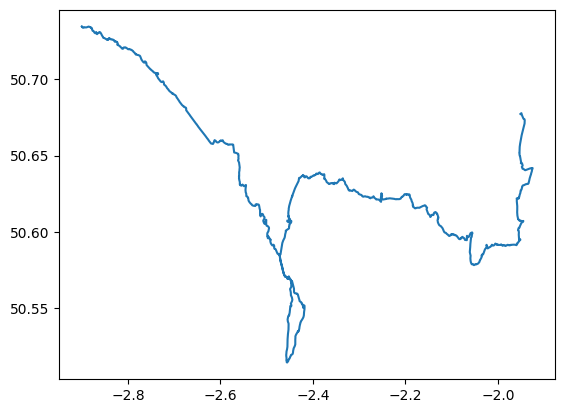

In [167]:
plt.plot(coords['lon'].values, coords['lat'].values)

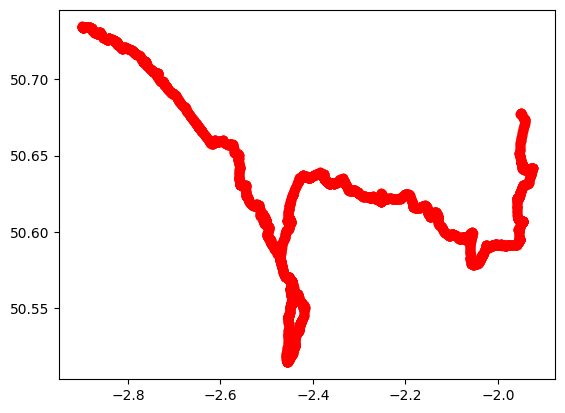

In [168]:
plt.plot(coords['lon'].values, coords['lat'].values, 'ro')

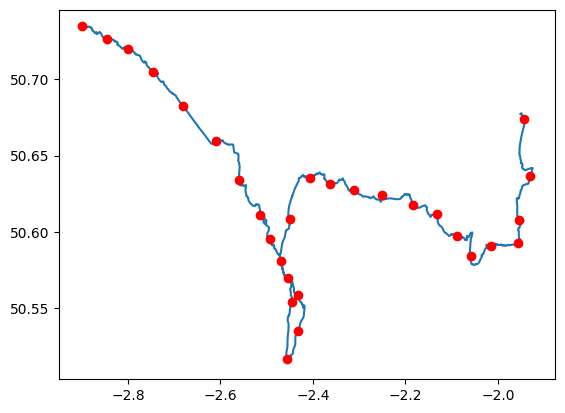

In [169]:
plt.plot(coords['lon'].values, coords['lat'].values)
plt.plot(coords['lon'].values[::150], coords['lat'].values[::150], 'ro')

4223 points reduced to 185


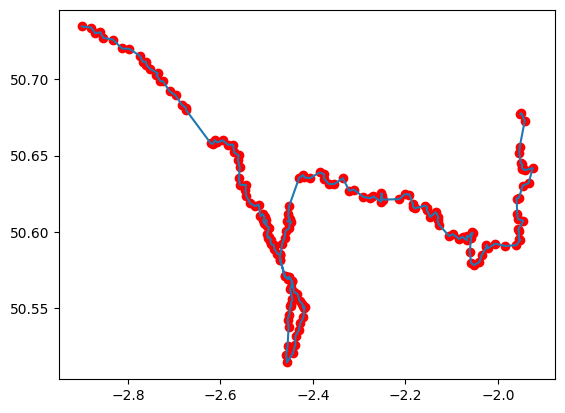

In [170]:
simple_coords = rdp(coords[['lon', 'lat']].values, epsilon = 1e-3)
print("{} points reduced to {}".format(coords.shape[0], simple_coords.shape[0]))
plt.plot(simple_coords[:,0], simple_coords[:,1],'ro')
plt.plot(simple_coords[:,0], simple_coords[:,1]);

In [171]:
import folium
from folium.plugins import HeatMap
import base64

# Create a Folium map
m = folium.Map()

# Define GPS path coordinates (assuming you have them stored in a DataFrame 'gps_data' with columns 'lat' and 'lon')
gps_path = list(zip(coords['lat'], coords['lon']))

# Add GPS path as a polyline to the map
folium.PolyLine(locations=gps_path, color='blue', weight=2.5, opacity=0.8).add_to(m)

# Calculate bounding box of GPS path coordinates
max_lat = max(coords['lat'])
min_lat = min(coords['lat'])
min_lon = min(coords['lon'])
max_lon = max(coords['lon'])

# Set map's zoom and center to show only the GPS path
m.fit_bounds([(min_lat, min_lon), (max_lat, max_lon)])

# Display the map
m


In [172]:
# segment.points[0].speed, segment.points[-1].speed = 0., 0.
# gpx_file.add_missing_speeds()
# speed = np.array([p.speed * 3.6 if p.speed is not None else 0.0 for p in segment.points])

# plt.plot(speed)
# plt.xlabel('Point Index')
# plt.ylabel('Speed (km/h)')
# plt.grid(True)
# plt.show()

In [173]:
# Define deviation parameters
min_deviation_distance = -0.0004  # Minimum deviation distance
max_deviation_distance = 0.0004   # Maximum deviation distance
max_deviation_angle = 45         # Maximum deviation angle in degrees

# Generate random deviation distances and angles for each point in the DataFrame
num_points = len(coords)
random_deviation_distances = np.random.uniform(min_deviation_distance, max_deviation_distance, num_points)
random_deviation_angles = np.random.uniform(0, max_deviation_angle, num_points)  # Random angles between 0 and max_deviation_angle

# Convert random angles to radians
random_deviation_angles_radians = np.radians(random_deviation_angles)

# Calculate deviation in latitude and longitude for each point
deviation_distance_lat = random_deviation_distances * np.cos(random_deviation_angles_radians)
deviation_distance_lon = random_deviation_distances * np.sin(random_deviation_angles_radians)

# Apply deviation to the existing GPS data
decoy_coords = coords.copy()  # Create a copy of existing coordinates
decoy_coords['lat'] += deviation_distance_lat
decoy_coords['lon'] += deviation_distance_lon

# Display the first few rows of the decoy coordinates
print(decoy_coords.head())


         lat       lon       ele
0  50.734425 -2.900108  3.400000
1  50.734227 -2.900289  3.400000
2  50.734179 -2.899753  2.200000
3  50.734296 -2.899612  2.175167
4  50.734522 -2.899525  2.156287


4223 points reduced to 238


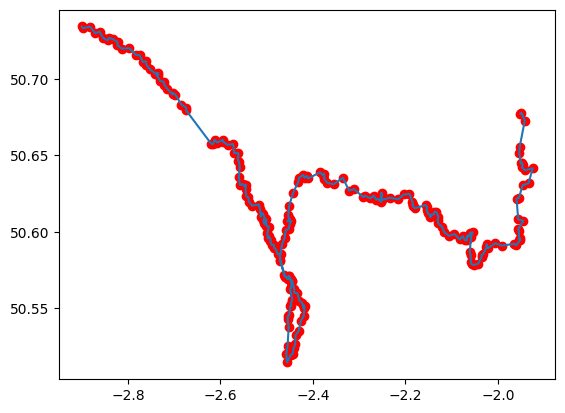

In [174]:
simple_coords = rdp(decoy_coords[['lon', 'lat']].values, epsilon = 1e-3)
print("{} points reduced to {}".format(decoy_coords.shape[0], simple_coords.shape[0]))
plt.plot(simple_coords[:,0], simple_coords[:,1],'ro')
plt.plot(simple_coords[:,0], simple_coords[:,1]);

In [175]:
# Create a Folium map with the coordinates from the 'coords' dataframe
m = folium.Map()

# Define GPS path coordinates for 'coords' (assuming you have them stored in a DataFrame 'coords' with columns 'lat' and 'lon')
coords_path = list(zip(coords['lat'], coords['lon']))

# Add GPS path for 'coords' as a polyline to the map (in blue color)
folium.PolyLine(locations=coords_path, color='blue', weight=2.5, opacity=0.8).add_to(m)

# Define GPS path coordinates for 'decoy_coords' (assuming you have them stored in a DataFrame 'decoy_coords' with columns 'lat' and 'lon')
decoy_path = list(zip(decoy_coords['lat'], decoy_coords['lon']))

# Add GPS path for 'decoy_coords' as a polyline to the map (in red color)
folium.PolyLine(locations=decoy_path, color='red', weight=2.5, opacity=0.8).add_to(m)

# Calculate bounding box of GPS path coordinates
max_lat = max(coords['lat'])
min_lat = min(coords['lat'])
min_lon = min(coords['lon'])
max_lon = max(coords['lon'])
m.fit_bounds([(min_lat, min_lon), (max_lat, max_lon)])
# Display the map
m


In [176]:
from geopy.distance import geodesic
m = folium.Map()
# Function to calculate distance between two coordinates using Haversine formula
def calculate_deviation(coord1, coord2):
    return geodesic(coord1, coord2).kilometers

# Define every 50th index to calculate distances
step = 50

# Initialize a list to store the distances
deviations = []

# Iterate through every 100th index and calculate the distance between coords and decoy_coords
for i in range(0, min(len(coords), len(decoy_coords)), step):
    deviation = calculate_deviation((coords.iloc[i]['lat'], coords.iloc[i]['lon']),
                                  (decoy_coords.iloc[i]['lat'], decoy_coords.iloc[i]['lon']))
    deviations.append((i, deviation))

# Add distance markers to the map
for index, deviation in deviations:
    coord = (coords.iloc[index]['lat'], coords.iloc[index]['lon'])
    if deviation <= 0.01:
      colour = 'green'
    elif deviation >= 0.04:
      colour = 'red'
    else:
      colour = 'blue'
    m.add_child(folium.Marker(location=coord,
                              popup=f"Deviation from path: {deviation:.2f} km",
                              icon=folium.Icon(color=colour)))

# Calculate bounding box of GPS path coordinates
max_lat = max(coords['lat'])
min_lat = min(coords['lat'])
min_lon = min(coords['lon'])
max_lon = max(coords['lon'])
m.fit_bounds([(min_lat, min_lon), (max_lat, max_lon)])
# Display the updated map
m


In [177]:
m = folium.Map()

# Convert coords dataframe into a list of tuples
coords_list = list(zip(coords['lat'], coords['lon']))

# Iterate over every 150th index of decoy_coords
for index in range(0, len(decoy_coords), 150):
    # Get the current point from decoy_coords
    current_point = (decoy_coords.iloc[index]['lat'], decoy_coords.iloc[index]['lon'])
    # Calculate the nearest point on the line from current_point
    nearest_point_on_line = min(coords_list, key=lambda point: distance(point, current_point))
    # Calculate perpendicular distance
    perp_dist = geodesic(current_point, nearest_point_on_line).kilometers
    # Add marker to the map
    if perp_dist < 0.02:
        colour = 'green'
    elif perp_dist >= 0.05:
        colour = 'red'
    else:
        colour = 'blue'
    folium.Marker(location=current_point,
                  popup=f"Perpendicular Distance: {perp_dist:.2f} km",
                  icon=folium.Icon(color=colour)).add_to(m)
# Define GPS path coordinates for 'coords' (assuming you have them stored in a DataFrame 'coords' with columns 'lat' and 'lon')
coords_path = list(zip(coords['lat'], coords['lon']))

# Add GPS path for 'coords' as a polyline to the map (in blue color)
folium.PolyLine(locations=coords_path, color='blue', weight=2.5, opacity=0.8).add_to(m)

# Define GPS path coordinates for 'decoy_coords' (assuming you have them stored in a DataFrame 'decoy_coords' with columns 'lat' and 'lon')
decoy_path = list(zip(decoy_coords['lat'], decoy_coords['lon']))

# Add GPS path for 'decoy_coords' as a polyline to the map (in red color)
folium.PolyLine(locations=decoy_path, color='red', weight=2.5, opacity=0.8).add_to(m)
# Display the map

# Calculate bounding box of GPS path coordinates
max_lat = max(decoy_coords['lat'])
min_lat = min(decoy_coords['lat'])
min_lon = min(decoy_coords['lon'])
max_lon = max(decoy_coords['lon'])
m.fit_bounds([(min_lat, min_lon), (max_lat, max_lon)])
m